# Advanced AI for Business Applications 
## Attention Mechanism, Transformer Architecture, and Large Language Models

#### Resources and references from MSBA 6461, Spring 2024, Mochen Yang   
Professor's GitHub link: https://github.com/mochenyang/MSBA6460-Advanced-AI.git

# Table of Contents
1. [Attention Mechanism](#attention)
    - [What is it and Why do We Need it?](#attention_motivation)
    - [Technical Details of Attention Mechanism](#attention_tech)
    - [Implement Attention Mechanism in Keras](#attention_implement)
    - [(Optional) A General Formulation of Attention Mechanism](#attention_general)
1. [Transformer Architecture](#transformer)
    - [What is the Transformer Architecture?](#transformer_intro)
    - [Key Component of Transformer: Self Attention](#transformer_components)
    - [Other Components of Transformer and its Implementation](#transformer_other)
1. [Application Case: BERT](#bert)
    - [What is BERT?](#bert_intro)
    - [Use BERT](#bert_example)
1. [Application Case: GPT](#gpt)
1. [Large Language Models](#llm)
1. [Additional Resources](#resource)

# Attention Mechanism <a name="attention"></a>

## What is it and Why do We Need it? <a name="attention_motivation"></a>

The basic encoder-decoder architecture discussed in the last module has achieved significant successes in applications such as machine translation. However, it also has some notable limitations. One important limitation that motivated the attention mechanism is the observation that **different parts of the input sequence are not equally important for predicting the output sequence, that is, different words in the input sequence carry different weights in terms of predicting different words in the output sequence.** (see the simple example below). The basic encoder-decoder architecture cannot capture this aspect, because for each input sequence we only get a _single_ context vector that is used to generate the entire output sequence.

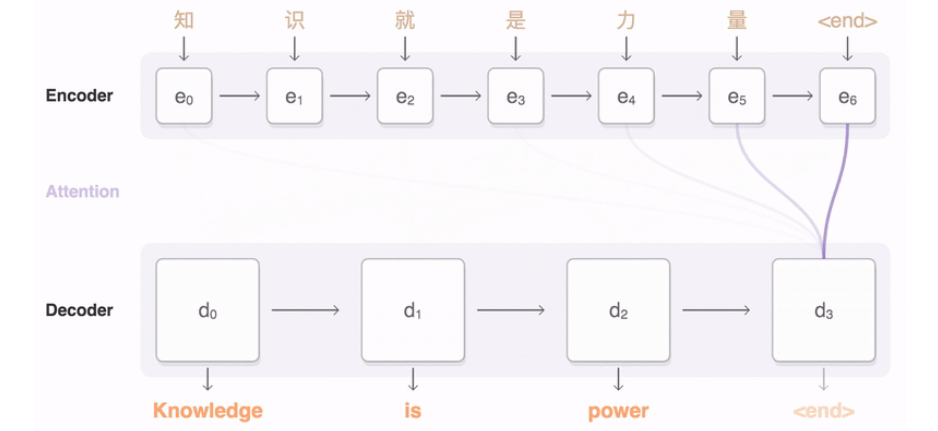

image credit: https://medium.com/eleks-labs/neural-machine-translation-with-attention-mechanism-step-by-step-guide-989adb12127b

This also naturally gives rise to the basic idea behind the attention mechanism: Instead of a single context vector, we now compute one context vector specifically for generating one word in the output sequence. That context vector should encode the information from input sequence that is most useful for predicting the target word in output sequence. In other words, we "align" the context vector for each target word in the output sequence with words in the input sequence.

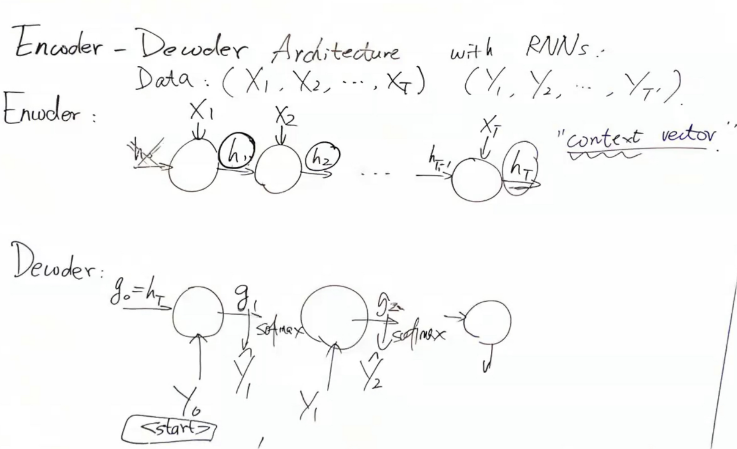

**h_t != h_1 + ... + h_t-1, it's not simple additive formula; it's more complex**

<font color="red">**Intuition of Attention Mechanism: leverage the more granular information that is stored in h_1, h_2, ..., h_t, and somehow insert that more granular information into the process of predicting y_1, y_2, ... (i.e. generating y_1_hat, y_2_hat, ...), as a pose to hoping that final cumulative h_t capture and predict everything. We are sharing the burden of prediction onto the more granular information stored along the encoding process.**</font>

## Attention Mechanism at time step t

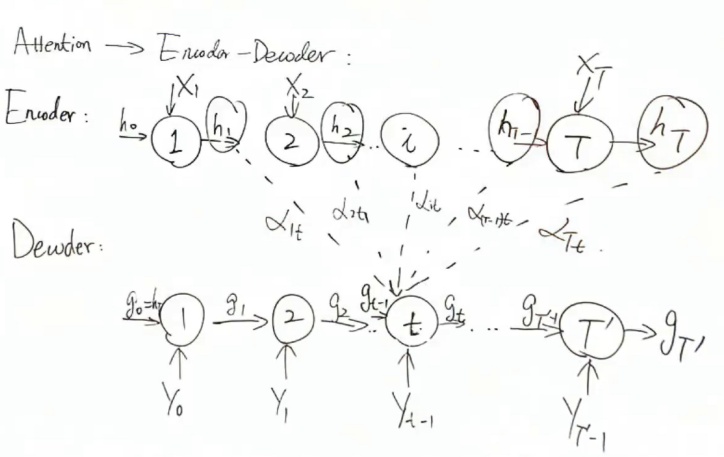

(Note that we just ignore the softmax activation function here; don't forget it)  
We basically take weighted average of the more granular information, and the weights are something we want the model to learn. 

The information we have at this time step:  
1. All the h, i.e. h_i, i=1, 2, ..., t  
2. g_t-1, it is what the decoder knows immediately before step t 
3. 

## End to end learning 
The entire learning process is a part of what the model is trying to optimize for.  
Consider you model has a lot of components and each component has its parameter that need to be figured out through gradient descending, end-to-end learning basically means that the model learn those components and their corresponding parameters together in the entire learning process.  

The way those alphas are learned is exactly the same as how the parameters of the RNN or embedding are learned.  

## Technical Details of Attention Mechanism <a name="attention_tech"></a>

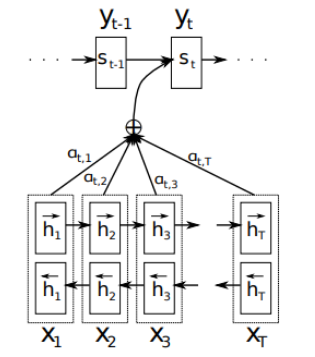

image credit: Figure 1 in https://arxiv.org/pdf/1409.0473.pdf. 

<font color="blue">Note:</font> I'm going to use slightly different notations than what's in the above figure, in order to be consistent with other parts of this notebook. Specifically, I will use $t$ to index positions in the input sequence and $i$ to index positions in the output sequence (whereas they are $1, \ldots, T$ and $t$ in the figure). Accordingly, I use $h_t^{(encoder)}$ and $h_i^{(decoder)}$ to represent encoder/decoder hidden states, whereas the same things are denoted as $h_t$ and $s_t$ in the above figure.

**The encoder RNN**: same as the encoder step in a standard encoder-decoder architecture, except that we often use a bi-directional RNN (rather than a one-directional RNN). <font color="blue">Intuition for using bi-directional RNN:</font> we want the hidden states of the encoder RNN to contain information of both the preceding and following words in the input sequence, to help better learn the "alignment" with the target word. Formally, the forward and backward pass are:
$$\overrightarrow{h_t^{(encoder)}} = f(\overrightarrow{h_{t-1}^{(encoder)}}, x_t)$$
$$\overleftarrow{h_t^{(encoder)}} = f(\overleftarrow{h_{t+1}^{(encoder)}}, x_t)$$
and we concatenate the two to form the hidden state of encoder RNN at time $t$, i.e.,
$$h_t^{(encoder)} = \big[\overrightarrow{h_t^{(encoder)}}, \overleftarrow{h_t^{(encoder)}} \big]$$

**The context vector**: the context vector for target word $i$ (in the output sequence) is a **weighted sum** of all encoder hidden states:  
**<font color = 'red'>How important does each position in the encoder to a specific position in decoder?</font>**  
    
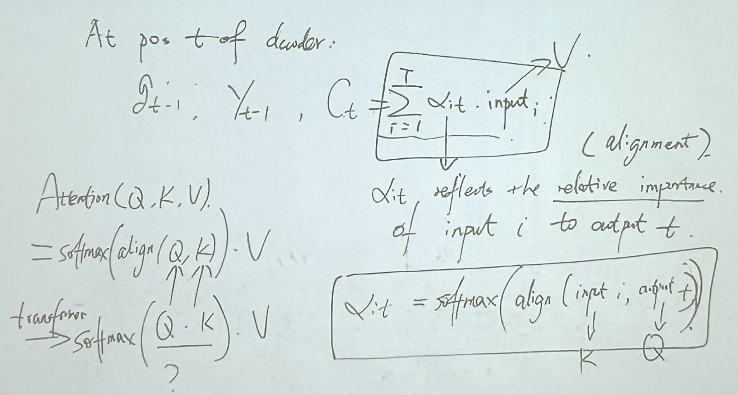

$$\boldsymbol{C_i} = \sum_{t=1}^{T} \alpha_{it} h_t^{(encoder)}$$
Here, $\alpha_{it}$ are attention weights and, intuitively, they specify "how much attention" should be paid to each position in the input sequence when deriving the representation of $i$-th word in the output sequence. So where does the weights, $\alpha_{it}$, come from? They are learned / trained jointly with other parameters as part of the entire model. More specifically, 
$$\alpha_{it} = \frac{\exp(e_{it})}{\sum_{k=1}^T \exp(e_{ik})}$$

where $e_{it}$ are often referred to as "scores" (and sometimes "energy"). Researchers have proposed multiple types of attention mechanisms, which differ in the way $e_{it}$ are computed. For example:  

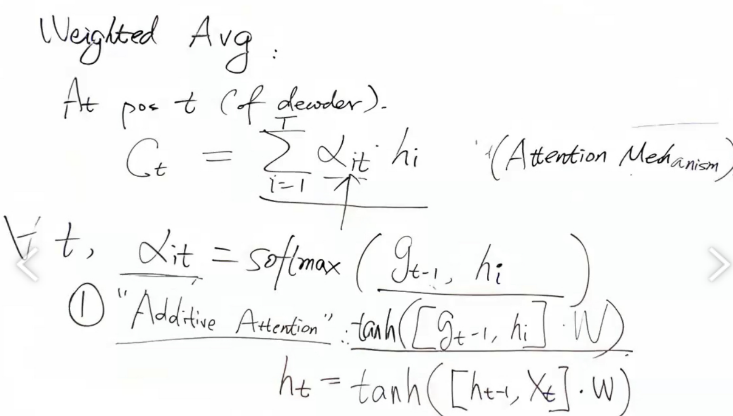

**Concat the attention machenism:**  
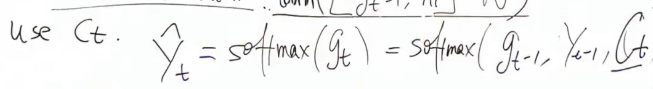

<font color = 'blue'>**(Note that h_decoder = g in the image)**  
From the image we can see, the way to do attention machenism at time step t is equivalent to what we will do at step t in the RNN.</font>

- <font color = 'red'>Additive Attention (aka Bahdanau Attention): $e_{it} = tanh([h_{i-1}^{(decoder)}, h_t^{(encoder)}], \boldsymbol{W})$. In other words, the scores are computed via a (standard) feed-forward neural network with a single hidden layer and $tanh$ activation.</font>
- **<font color = 'red'>Dot-Product Attention (often used in transformer architecture): $e_{it} = (h_{i-1}^{(decoder)})^{'} h_t^{(encoder)}$, i.e., the dot product between $h_{i-1}^{(decoder)}$ and $h_t^{(encoder)}$.</font>**
- Other types of attention mechanisms: I highly recommend taking a look at [this article](https://lilianweng.github.io/lil-log/2018/06/24/attention-attention.html) for details.

**The decoder RNN**: at time step $i$ of the decoder RNN, it takes the hidden state from step $i-1$ as well as the context vector $\boldsymbol{C_i}$ as input to compute the hidden state at step $t$ and then produce a prediction at that step. So,
1. Compute next hidden state as $h_i^{(decoder)} = f(h_{i-1}^{(decoder)},y_{i-1},\boldsymbol{C_i})$. The context vector $\boldsymbol{C_i}$ is concatenated with the other inputs and feed into the activation function;
2. Predict $\hat{y_i} = softmax(h_i^{(decoder)})$ as the next word in sequence;
3. Repeat steps 1-2 until termination.

## Attention Mechanism Implementation <a name="attention_implement"></a>

The [`tf.keras.layers.Attention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention) implements both the additive attention (set `score_mode = "concat"`) and the dot product attention (set `score_mode = "dot"`). For other types of attention mechanisms, you may need to do some implementation yourself.

## (Optional) A General Formulation of Attention Mechanism <a name="attention_general"></a>

Attention mechanism, in general, can be formulated using the (somewhat abstract and not very intuitive) terms of "query", "key", and "value". In NLP settings:
- Query $Q$ typically refers to words in the output / target sequence;
- Key $K$ and Value $V$ typically refer to words in the input sequence.

Then, the context vector (aka context embeddings) produced by the attention mechanism is computed as:

$$Attention(Q, K, V) = \boldsymbol{\alpha} V$$

where the attention weights $\boldsymbol{\alpha}$ is a softmax transformation of certain function over $(Q, K)$ that quantifies the "alignment" between $Q$ and $K$, i.e.,

$$\boldsymbol{\alpha} = softmax(align(Q, K))$$

In additive attention, $Q$ is the decoder hidden states and $K,V$ are encoder hidden states, and $align(.)$ is the $tanh$ function applied over a concatenation of $Q$ and $K$.

In dot-product attention, $Q$ is the decoder hidden states and $K,V$ are encoder hidden states, and $align(.)$ is simply the dot product.

In general, $align(.)$ can be any function that is capable of describing the degree of "alignment", or very loosely speaking, similarity / association, between the query and key vectors.

# Transformer <a name="transformer"></a>

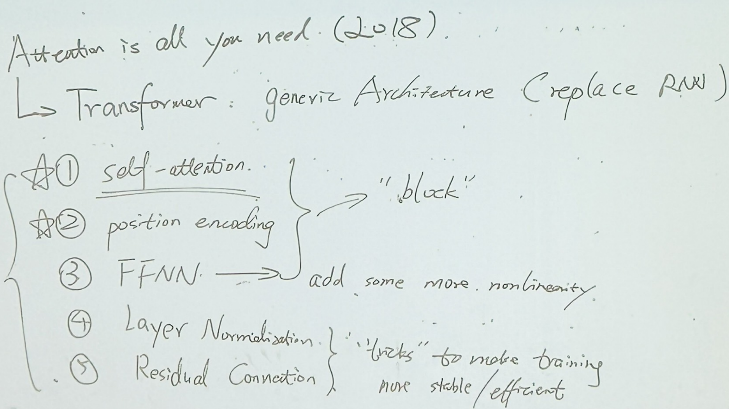

There are 3 parts of the components in the transformer: **encoder**, **decoder**, and a **block** between them.  
As shown in the image, the first three components are something in a transformer, and the latter two are tricks to make training more stable/efficient.  

## What is the Transformer Architecture? <a name="transformer_intro"></a>

The transformer architecture represents one of the most recent key breakthroughs in AI research. It has been applied to representation learning tasks for various different types of data, including text, image, video, time series, etc. In addition to its wide applicability, it is also responsible for many state-of-the-art results / performances in AI. Here, we focus on the transformer architecture for language understanding.

The transformer architecture largely follows the same encoder-decoder structure, but seeks to completely throw away the RNNs for encoder/decoder, and only uses (a particular kind of) attention mechanism combined with fully-connected feed-forward neural networks (i.e., non-recurrent). 

<font color="red">But why would you want to throw away the RNNs?</font> One of the key reasons is computational complexity. In a RNN, computations have to be done sequentially (e.g., processing one word after another), which prohibits parallelization. As a result, large-scale tasks with RNNs may become very slow. As you will see, most of the computations in a transformer (especially the self-attention component) can be done in a one-shot or parallel manner.

There are a number of technical components to a transformer architecture (see figure below), including self-attention, positional encoding, layer normalization + residual connection. I explain the intuition behind these components, with an emphasis on the self-attention mechanism. The goal here is not to understand every single detail of a transformer model (which is still actively evolving as the field progresses), but to get a basic sense of it.

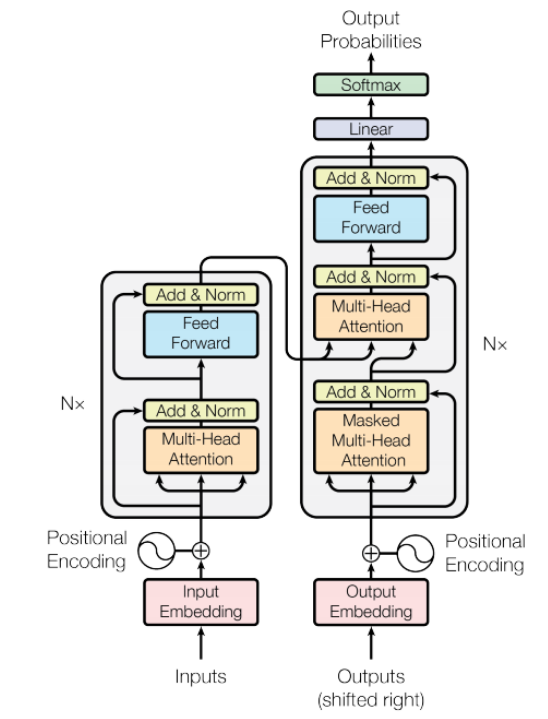

image credit: [Attention is all You Need](https://arxiv.org/pdf/1706.03762.pdf) (Figure 1)

## Key Component of Transformer: Self-Attention <a name="transformer_components"></a>

The attention mechanism that we discussed before can be thought of as a "layer" that sits between an encoder and a decoder, which allows the decoder RNN to "pay attention to" different positions of the encoder hidden states. The transformer relies on the same attention mechanism (with a twist), namely **self-attention**.

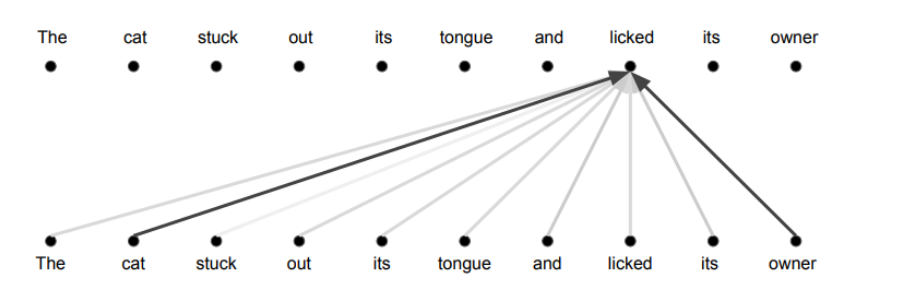

image credit: [Self-Attention For Generative Models](https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1194/slides/cs224n-2019-lecture14-transformers.pdf)

For example, if we train the model well, it will learn that the focal word "licked" is strongly related to "cat" and "owner", we are forcing more information of "cat" and "owner" fo flow into "licked", so it no longer just means that action, now it has relation with cat and owner.  

You can think of self-attention as a mechanism that applies to an input sequence _itself_ (like the visualization above), in order to generate a representation of the sequence that encodes information about how different words in the sequence are related to each other. In a (non-rigorous) sense, it allows the representation of the input sequence to contain information about "interactions" among different words in the sequence. Importantly, the entire process of calculating self-attention representation of an input sequence does NOT involve any RNNs or word-by-word recurrence. That's the point of transformer - it is a highly parallel architecture.

Technically speaking, self-attention is achieved by applying one of the attention mechanisms discussed before and using the same sequence as both input and output. As a result, you get **contextual vector / embedding** for each token in the sequence. You can also create an embedding representation of the entire input sequence, by simply averaging across the embeddings of all words in that sequence. This is a form of **pooling**.

(Optional) More technical details about self-attention and how it is used in the transformer architecture:
In a transformer architecture, encoder and decoder each contains several "blocks" (note that the original transformer paper calls these "layers"). Each block contains a self-attention component and a fully-connected feed-forward neural net. These blocks are stacked; meaning the outputs of a previous block become the inputs of the next block. In other words, from the original input tokens to the final embedding representations, you will go through several times of self-attention and non-linear transformation.

More formally, Let $e_t$ denote the input embedding representations at the $t$-th position to a given transformer block, then, (dot-product) self-attention transforms the representations to
$$e_t' = softmax\left( \frac{e_t^T e_1}{\sqrt{D}}, \ldots, \frac{e_t^T e_T}{\sqrt{D}} \right) e_t$$
where $\sqrt{D}$ is a scaling parameter based on the embedding dimension to make sure that the embeddings don't "blow up" when dimension is high ($e_t^T e_i$ tends to grow as $d$ increases). If you re-write the above in matrix terms, you will see that it's basically the dot-product attention mechanism where key, query, and value are all the same input embeddings. Next, the self-attention transformed embeddings go through a feed-forward neural net layer with a RELU activation followed by a linear projection:
$$e_t'' = b_2 + W_2 RELU(b_1 + W_1 e_t')$$
The transformed embedding $e_t''$ passes on to the next block (or to the decoder if this is the last encoder block).

One more nuance: to enable even more parallelism, people may use something called a **Multi-Head Self-Attention**. The technical details of it are less relevant here, but here's the high-level analogy: you first cut the $D$-dimension embedding into $h$ smaller pieces (each with $D/h$ dimensions), apply the same self-attention mechanism to each piece (in parallel), and then concatenate the $h$ pieces into the final embedding. See [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf) Section 3.2.2 for more information if you are interested.

## Other Components of Transformer and its Implementation <a name="transformer_other"></a>

In addition to self-attention, the transformer architecture also uses several other technical elements, such as positional encoding, layer normalization, and residual connection. Below are some optional content on these elements. The [Additional Resources](#resource) section lists articles you can read for mroe information, and for a detailed demonstration of how to implement a transformer model.

### (Suppliment) Multi-head attention
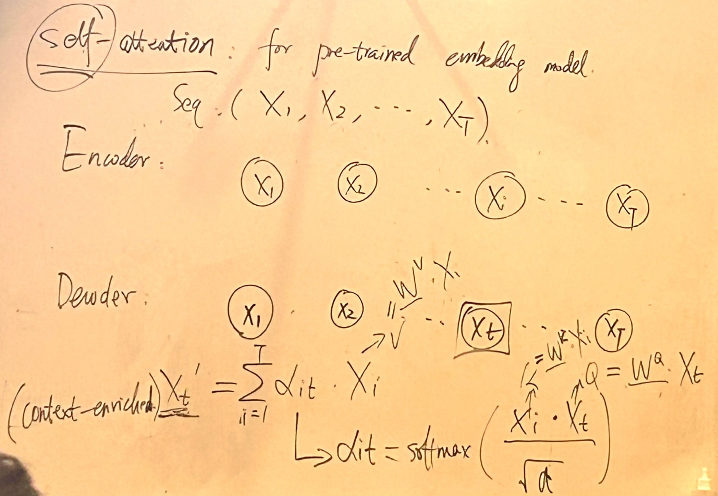

It's like duplicating the "whole building" and calculate the weights independently, and it becomes some learnable weights for the model to be trained.  

**<font color="red">Note that there's no sequencial components here</font>**  
To fix this problem: Position enfoding (bring back the sequentiality by adding the position information to the same words)  

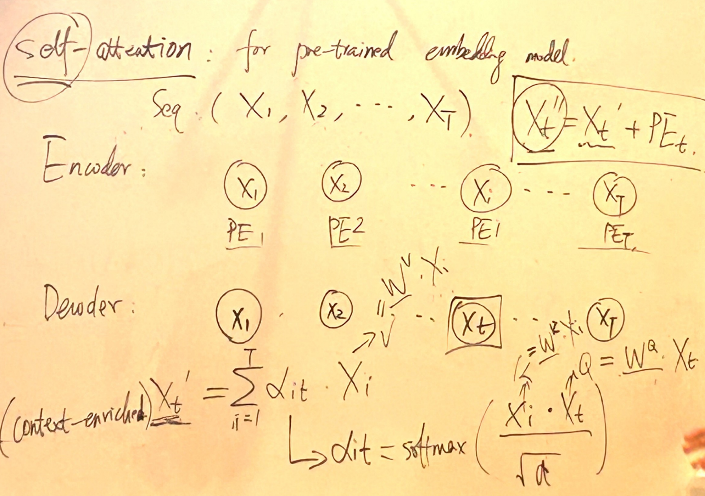

**X_t_double_prom is the representation with position information.**

### (Optional) Positional Encoding

Remember that we throw away the encoder and decoder RNNs, and only rely on self-attention to generate representations of the sequences? Without the sequential RNNs, the model now does not know the sequence of words in the input or output. To counter this loss of information, we try to encode the position of a word in a sequence into the embedding, using **Positional Encoding**. The positional encoding for each word at each position is another vector of the same dimension as the word embedding.

In the original paper that proposed transformer, the positional encoding is calculated as follows:
$$PE(pos, 2i) = \sin(\frac{pos}{10000^{2i/D}})$$
$$PE(pos, 2i+1) = \cos(\frac{pos}{10000^{2i/D}})$$
where $pos$ is a particular position in a sequence and $i \in {0, ..., D/2}$ is a running index. <font color="red">What does it mean? Let me explain with a small example.</font> 

Suppose you have an input sequence of 5 words, $(e_1,\ldots, e_5)$, and each $e_t$ is a $4$-dimensional embedding (i.e. $D = 4$). Now you want to also encode the positions of each word. For the sake of demonstration, let's say you want to encode the second position, i.e., $pos=2$. You would use the formula above to compute the following:
- Set $i=0$, $PE(2, 0) = \sin(\frac{2}{10000^0})=\sin(2) \approx 0.91$ and $PE(2, 1) = \cos(\frac{2}{10000^0})=\cos(2) \approx -0.42$;
- Set $i=1$, $PE(2, 2) = \sin(\frac{2}{10000^{0.5}}) \approx 0.02$ and $PE(2, 3) = \cos(\frac{2}{10000^{0.5}})=\cos(2) \approx 1.00$. Stop here because your embedding only has 4 dimensions.
Then, the embedding with positional encoding for the second word in this sequence will become:
$$e_2 + [0.91, -0.42, 0.02, 1.00]$$

This works because, after injecting the positional encoding, _the second word in this sequence will have a different embedding than the same word appearing at a different position in a different sequence_. Essentially, this allows the embedding to contain position-specific information that can help learning. Finally, why using the trigonometry functions? It's mostly for mathematical convenience and it works in practice.

<font color="blue">If you are comfortable with trigonometry... </font> Basically, the above positional encoding function adds a position-specific vector of the following form:
$$\left[\sin\left( \frac{pos}{10000^0} \right), \cos\left( \frac{pos}{10000^0} \right), \sin\left( \frac{pos}{10000^{2/D}} \right), \cos\left( \frac{pos}{10000^{2/D}} \right), \ldots, \sin\left( \frac{pos}{10000} \right), \cos\left( \frac{pos}{10000} \right) \right]$$
Due to the shapes of sine and cosine functions, this vector will be different for $pos \in \{1, \ldots, 10000\}$, thereby allowing you to differentiate positions up to length 10000.

### (Optional) Layer Normalization and Residual Connection

Both layer normalization and residual connection are tricks in deep learning to aid with training large / deep networks. Their intuitions are as follows:

1. **Layer Normalization** performs a standardization (i.e., $\frac{x - E(x)}{SD(x)}$) over all inputs in a given layer, so that the "normalized" inputs have mean 0 and sd 1. In the transformer architecture, within each block, the input embeddings (corresponding to all tokens in a single sequence) to the self-attention and to the feed-forward layers each go through a layer normalization operation. As a result, the normalized embeddings have mean 0 and sd 1.
2. **Residual Connection** allows the original inputs to a layer to directly contribute to the outputs of that layer _in addition_ to any transformations imposed by the layer (i.e., allowing the inputs to "skip" the transformations). Informally, consider some inputs $X$ to a hidden layer in MLP that applies a nonlinear transformation $f()$. Without residual connection, the outputs from this layer would be $f(X)$. With residual connection, it will be $X + f(X)$. <font color="red">Why doing this?</font> Because it allows the gradient (during training) to directly connect with the original inputs $X$ in addition to through $f(X)$.

Putting everything together, what actually goes on inside each transformer block is the following: suppose $E$ represents the matrix of (positionally encoded) embedding inputs to the block. It first goes through self-attention:
$$E' = \text{self-attention}(E)$$
Then, apply residual connection and layer normalization, you get:
$$E'' = \text{LayerNorm}(E + E')$$
Next, it goes through the feed-forward neural net:
$$E''' = FFNN(E'')$$
Finally, apply residual connection and layer normalization again:
$$E'''' = \text{LayerNorm}(E'' + E''')$$

# Application Case: BERT <a name="bert"></a>

## What is BERT? <a name="bert_intro"></a>

BERT stands for _**B**idirectional **E**ncoder **R**epresentations from **T**ransformers_. It is a **language representation model**, which means it takes raw text and generate a meaningful representation (e.g., embedding) of it. It was developed by Google in 2018. With everything we have discussed so far, you are ready to make sense of all the key components of BERT:

1. **B**idirectional means that, during training, the input sequences and its reverse sequence are both used;
2. **E**ncoder **R**epresentations means that the model is aiming to generate representation of the input sequence, i.e., it acts like an encoder;
3. **T**ransformers means that BERT uses a transformer architecture with self-attention.

## Use BERT <a name="bert_example"></a>

Google has released a number of different BERT models, trained with different hyperparameters. [Here is a directory of all those models](https://www.tensorflow.org/tutorials/text/classify_text_with_bert#choose_a_bert_model_to_fine-tune). You see that each model is identified by three parameters:
- $L$: this is the number of transformer blocks. You can think of it as number of "layers";
- $H$: this is the dimension of embedding. We called this $D$ in our discussion of transformer;
- $A$: this is the number of heads in multi-head self-attention. This means cutting the embedding into $A$ pieces and apply self-attention to each piece.

You can access pre-trained BERT models and potentially fine-tune them for your own ML tasks via [Hugging Face](https://huggingface.co/), an online platform that hosts many commonly used pre-trained models. In the following example, we access a basic BERT model and use it to encode some text. See this [page](https://huggingface.co/bert-base-uncased) for detailed documentation.

In [3]:
# install transformer package from Hugging Face
!pip install transformers --user

  Using cached transformers-4.39.3-py3-none-any.whl.metadata (134 kB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl.metadata (12 kB)
  Using cached tokenizers-0.15.2-cp38-none-win_amd64.whl.metadata (6.8 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl.metadata (6.8 kB)
Using cached transformers-4.39.3-py3-none-any.whl (8.8 MB)
Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
Using cached tokenizers-0.15.2-cp38-none-win_amd64.whl (2.2 MB)
Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
from transformers import BertTokenizer, TFBertModel

# fetch the pre-trained model (it will download a model file ~500M)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\Yvonne\AppData\Roaming\Python\Python38\site-packages\huggingface_hub\file_download.py:148: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Yvonne\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
# input text and encode
text = "We are using the BERT model!"
encoded_input = tokenizer(text, return_tensors='tf')
output = bert_model(encoded_input)

In [12]:
# Look at the tokenized input
# Question: what are tokens 101 and 102?
encoded_input

{'input_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[  101,  2057,  2024,  2478,  1996, 14324,  2944,   999,   102]])>, 'token_type_ids': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[0, 0, 0, 0, 0, 0, 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[1, 1, 1, 1, 1, 1, 1, 1, 1]])>}

In [13]:
# Look at the encoded input
# Question: what is the dimension of encoding?
# Question: why are there two encoding outputs? What are they?
output

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(1, 9, 768), dtype=float32, numpy=
array([[[ 0.10261209,  0.18043919, -0.00554929, ..., -0.166134  ,
          0.26679957,  0.35773745],
        [ 0.263622  , -0.21110201, -0.57594675, ..., -0.20186077,
          1.308478  , -0.14822024],
        [ 0.12224663, -0.15183868, -0.36246365, ..., -0.56034166,
          0.18197185,  0.45692527],
        ...,
        [ 0.487611  ,  0.05848615, -0.26846886, ..., -0.64023006,
         -0.01316616, -0.00961822],
        [-0.16868652, -0.17555293, -0.15778571, ...,  0.54957277,
          0.45626837, -0.39924195],
        [ 0.52467674,  0.37009996, -0.21517405, ...,  0.00148578,
         -0.5219994 , -0.30393368]]], dtype=float32)>, pooler_output=<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-8.78734827e-01, -3.25698197e-01, -3.28317106e-01,
         6.70523882e-01,  6.76294491e-02, -4.97857258e-02,
         8.80656004e-01,  2.76587784e-01, -1.80702090e-0

The next example shows how BERT can be used as an embedding layer to build a classification model. For illustration, the [sentiment classification dataset](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences) is used. 

In [3]:
# read and process data
text = []
label = []
for line in open("datasets/sentiment.txt"):
    line = line.rstrip('\n').split('\t')
    text.append(line[0])
    label.append(int(line[1]))
text = np.array(text)
label = np.array(label)

In [4]:
# Use BERT to encode texts
vectorized_text = tokenizer(text.tolist(), return_tensors='tf', padding=True)
bert_embeddings = bert_model(vectorized_text)['last_hidden_state']

In [30]:
# For illustration, build a LSTM model with BERT embeddings
embeddings = keras.layers.Input(shape = (bert_embeddings.shape[1], bert_embeddings.shape[2]))
masked_embeddings = tf.keras.layers.Masking(mask_value=0)(embeddings)
h_all, h_final, c_final = keras.layers.LSTM(units = 128,
                                            return_state = True)(masked_embeddings)
pred = keras.layers.Dense(units = 1,
                          activation='sigmoid')(h_final)

In [31]:
# Assemble model
model_bert_lstm = keras.Model(inputs = embeddings,
                              outputs = pred)

In [32]:
# configure training / optimization
model_bert_lstm.compile(loss = keras.losses.BinaryCrossentropy(),
                        optimizer='adam',
                        metrics=['accuracy'])

In [33]:
model_bert_lstm.summary()

Model: "functional_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 100, 768)]        0         
_________________________________________________________________
masking_4 (Masking)          (None, 100, 768)          0         
_________________________________________________________________
lstm_8 (LSTM)                [(None, 128), (None, 128) 459264    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 459,393
Trainable params: 459,393
Non-trainable params: 0
_________________________________________________________________


In [34]:
# training with 20% validation and 10 epochs.
model_bert_lstm.fit(x = bert_embeddings,
                    y = label,
                    batch_size = 32,
                    epochs = 10,
                    validation_split = 0.2)

Epoch 1/10
75/75 [==============================] - 7s 99ms/step - loss: 0.3688 - accuracy: 0.8313 - val_loss: 0.2423 - val_accuracy: 0.9033
Epoch 2/10
75/75 [==============================] - 6s 85ms/step - loss: 0.2231 - accuracy: 0.9142 - val_loss: 0.2508 - val_accuracy: 0.8983
Epoch 3/10
75/75 [==============================] - 6s 85ms/step - loss: 0.1931 - accuracy: 0.9283 - val_loss: 0.2370 - val_accuracy: 0.9050
Epoch 4/10
75/75 [==============================] - 6s 85ms/step - loss: 0.1470 - accuracy: 0.9450 - val_loss: 0.2318 - val_accuracy: 0.9067
Epoch 5/10
75/75 [==============================] - 7s 87ms/step - loss: 0.1195 - accuracy: 0.9592 - val_loss: 0.2716 - val_accuracy: 0.8867
Epoch 6/10
75/75 [==============================] - 7s 88ms/step - loss: 0.0976 - accuracy: 0.9646 - val_loss: 0.2464 - val_accuracy: 0.9050
Epoch 7/10
75/75 [==============================] - 7s 92ms/step - loss: 0.0735 - accuracy: 0.9762 - val_loss: 0.3454 - val_accuracy: 0.8850
Epoch 8/10
75

# Application Case: GPT <a name="gpt"></a>

Another set of famous applications of transformers is the Generative Pre-Training (GPT) models developed by [OpenAI](openai.com). Here are some resources for you to read:
- GPT-1: [Blog Post](https://openai.com/blog/language-unsupervised/), [Reserach Paper](https://www.cs.ubc.ca/~amuham01/LING530/papers/radford2018improving.pdf);
- GPT-2: [Blog Post](https://openai.com/blog/better-language-models/), [Research Paper](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf). GPT-2 is basically GPT-1 trained on much more data with much more parameters (1.5 Billion parameters), but the underlying model structure is largely the same;
- GPT-3: [Blog Post](https://openai.com/blog/openai-api/), [Research Paper](https://arxiv.org/pdf/2005.14165.pdf). Again, GPT-3 largely uses the same architecture as GPT-2, with much more parameters (175 billion parameters).
- GPT-4: [Blog Post](https://openai.com/research/gpt-4), [Research Paper](https://arxiv.org/abs/2303.08774). Detailed architecture is (intentionally) unclear. We know it's trained with the additional RLHF (Reinforcement Learning with Human Feedback). 

You can use GPT-family models via [Hugging Face](https://huggingface.co/gpt2) or [OpenAI API](https://platform.openai.com/).

# Large Language Models <a name="llm"></a>

BERT and GPT are both examples of Large Language Models (LLMs), which are language models that can process, "understand", and generate texts. They are "large" because they are often trained on enormous amount of textual data and have a huge number of parameters. They learn representations of a language, and can be further fine-tuned for a variety of different language tasks.

LLMs are perhaps the most exciting major advancement in AI currently. Here are some articles in popular press that discuss its implications and impact:
- [The emerging types of language models and why they matter](https://tcrn.ch/3Kj0njm)
- [How Large Language Models Will Transform Science, Society, and AI](https://hai.stanford.edu/news/how-large-language-models-will-transform-science-society-and-ai)
- [Codify Intelligence with Large Language Models](https://www.nvidia.com/en-us/deep-learning-ai/solutions/large-language-models/)
- [Large Language Models Will Define Artificial Intelligence](https://www.forbes.com/sites/garydrenik/2023/01/11/large-language-models-will-define-artificial-intelligence/?sh=44c9d418b60f)

Some pretty impressive recent LLMs:
- [Google LaMDA](https://blog.google/technology/ai/lamda/)
- [DeepMind Chinchilla](https://gpt3demo.com/apps/chinchilla-deepmind)
- [OpenAI ChatGPT](https://openai.com/blog/chatgpt/) and [GPT-4](https://openai.com/research/gpt-4)

<font color="blue">Some of my personal opinions: </font> A general trend in the development of language models is to _build extremely large models_, i.e., take the state-of-the-art architecture and train it with more and more parameters and on larger and larger datasets. However, looking back on what we have learned so far, you really need _fundamentally new ideas_ (e.g., from bag-of-words to embeddings, from simple RNNs to LSTMs, from RNNs + attention to transformers) to achieve significant (non-incremental) improvement. Therefore, although the transformer architecture is the current state-of-the-art, it is fundamentally unclear what else we need for the next breakthrough.

# Additional Resources <a name="resource"></a>

- Attention Mechanism:
    - Original research paper that proposed the attention mechanism: [Neural machine translation by jointly learning to align and translate](https://arxiv.org/pdf/1409.0473.pdf?utm_source=ColumnsChannel);
    - Implementation of attention: [Neural machine translation with attention](https://www.tensorflow.org/tutorials/text/nmt_with_attention);
- Transformer:
    - Original research paper that proposed the transformer architecture: [Attention Is All You Need](https://arxiv.org/pdf/1706.03762.pdf);
    - Original paper on self-attention: [Long Short-Term Memory-Networks for Machine Reading](https://arxiv.org/pdf/1601.06733.pdf);
    - Additional articles to learn about self-attention: [Illustrated: Self-Attention](https://towardsdatascience.com/illustrated-self-attention-2d627e33b20a), [Introduction of Self-Attention Layer in Transformer](https://medium.com/lsc-psd/introduction-of-self-attention-layer-in-transformer-fc7bff63f3bc);
    - Additional articles on other components in a transformer: [Layer Normalization](https://arxiv.org/abs/1607.06450), [Normalization Techniques in Deep Neural Networks](https://medium.com/techspace-usict/normalization-techniques-in-deep-neural-networks-9121bf100d8), [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385);
    - Implementation of Transformer: [Transformer model for language understanding](https://www.tensorflow.org/tutorials/text/transformer);
    - [Transformer for text classification](https://keras.io/examples/nlp/text_classification_with_transformer/)
    - Andrej Karpathy's [YouTube Tutorial](https://www.youtube.com/watch?v=kCc8FmEb1nY)
- BERT:
    - Original research paper that proposed BERT: [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805). In particular, Section 3 talks about BERT model architecture;
    - [Open Sourcing BERT: State-of-the-Art Pre-training for Natural Language Processing](https://ai.googleblog.com/2018/11/open-sourcing-bert-state-of-art-pre.html);
    - [Text Classification with BERT](https://www.tensorflow.org/tutorials/text/classify_text_with_bert).